In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier
import joblib

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder

In [2]:

# Carga de datos de base HEY BANCO
clients = pd.read_csv('base_clientes_final.csv', parse_dates=['fecha_nacimiento','fecha_alta'])
transactions = pd.read_csv('base_transacciones_final.csv', parse_dates=['fecha'])

# Definir horizonte de predicción (días de predicción) y fecha de corte
horizon_days = 30
cutoff_date = transactions['fecha'].max() - timedelta(days=horizon_days)

# Features con datos hasta cutoff_date
tx_train = transactions[transactions['fecha'] <= cutoff_date]
# Labels: si hay transacciones en periodo (cutoff_date, cutoff_date + horizon_days]
tx_future = transactions[
    (transactions['fecha'] > cutoff_date) &
    (transactions['fecha'] <= cutoff_date + timedelta(days=horizon_days))
]

# Construir features por cliente-comercio
grouped = tx_train.groupby(['id','comercio'])
records = []
for (cid, com), grp in grouped:
    recency = (cutoff_date - grp['fecha'].max()).days
    freq30 = grp[grp['fecha'] >= cutoff_date - timedelta(days=horizon_days)].shape[0]
    mean_amt = grp['monto'].mean()
    std_amt = grp['monto'].std()
    # Label: 1 si aparece en tx_future para ese cliente-comercio
    future_label = int(((tx_future['id']==cid) & (tx_future['comercio']==com)).any())
    records.append([cid, com, recency, freq30, mean_amt, std_amt, future_label])

feat = pd.DataFrame(records, columns=['id','comercio','recency','freq30','mean_amt','std_amt','label'])

# Añadir features demográficas
clients['age'] = (cutoff_date - clients['fecha_nacimiento']).dt.days / 365
clients['tenure'] = (cutoff_date - clients['fecha_alta']).dt.days

df = feat.merge(
    clients[['id','id_estado','age','tenure','tipo_persona','genero']],
    on='id', how='left'
)
df['std_amt'] = df['std_amt'].fillna(0)

# Codificación
le_com = LabelEncoder(); df['comercio_enc'] = le_com.fit_transform(df['comercio'])
le_tp  = LabelEncoder(); df['tipo_persona_enc'] = le_tp.fit_transform(df['tipo_persona'])
le_gen = LabelEncoder(); df['genero_enc'] = le_gen.fit_transform(df['genero'].fillna(''))

# Matrices X, y
X = df[['recency','freq30','mean_amt','std_amt','id_estado','age','tenure',
        'comercio_enc','tipo_persona_enc','genero_enc']]
y = df['label']

# División Train/Test aleatoria (o por clientes)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Entrenar modelo
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluación
y_pred_proba = model.predict_proba(X_test)[:,1]
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))
print(classification_report(y_test, model.predict(X_test)))

# Guardar modelo
joblib.dump(model, 'rf_model_timeaware.pkl')

ROC AUC: 0.8635254981241139
              precision    recall  f1-score   support

           0       0.81      0.82      0.82      2478
           1       0.76      0.75      0.75      1866

    accuracy                           0.79      4344
   macro avg       0.79      0.79      0.79      4344
weighted avg       0.79      0.79      0.79      4344



['rf_model_timeaware.pkl']

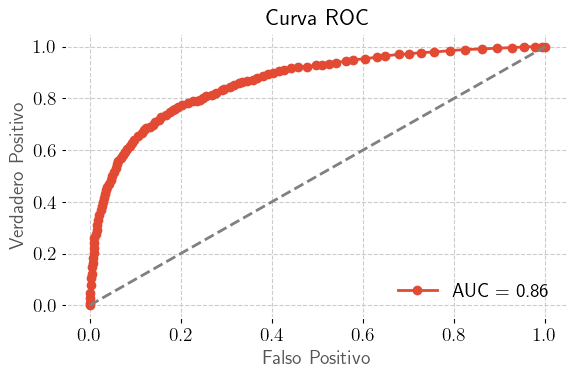

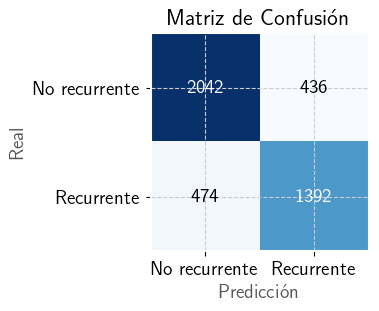

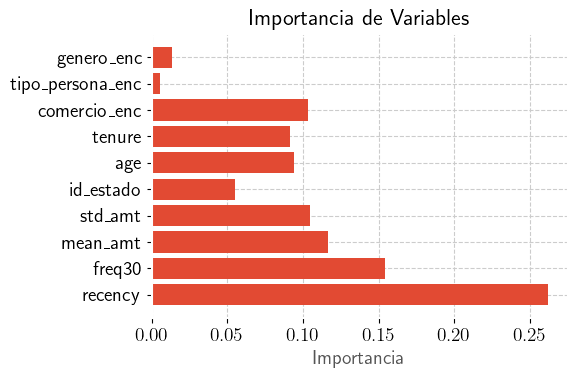

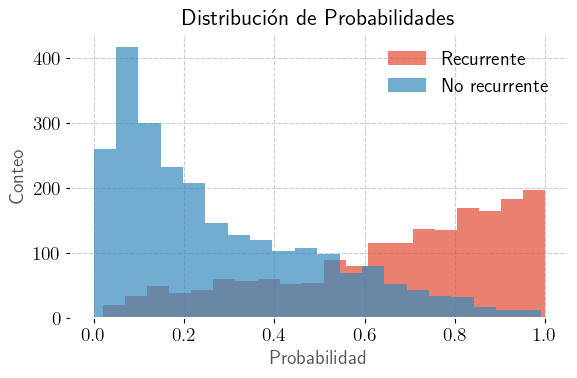

In [14]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix

# ————— Estilo “Julia-like” —————
plt.style.use('ggplot')  # base limpia y profesional
mpl.rcParams.update({
    'font.family': 'sans-serif',
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'axes.linewidth': 1.5,
    'lines.linewidth': 2,
    'lines.markersize': 6,
    'axes.grid': True,
    'grid.color': '#CCCCCC',
    'grid.linestyle': '--',
    'grid.linewidth': 0.8,
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'legend.frameon': False,
    'xtick.color': 'black',
    'ytick.color': 'black',
})

# 1) Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', marker='o')
ax.plot([0,1],[0,1], linestyle='--', color='gray')
ax.set(title='Curva ROC', xlabel='Falso Positivo', ylabel='Verdadero Positivo')
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()

# 2) Matriz de confusión
cm = confusion_matrix(y_test, model.predict(X_test))
clases = ['No recurrente','Recurrente']
fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(cm, cmap='Blues')
for i in range(2):
    for j in range(2):
        ax.text(j,i, cm[i,j], ha='center', va='center',
                color='white' if cm[i,j]>cm.max()/2 else 'black')
ax.set(title='Matriz de Confusión', xticks=[0,1], yticks=[0,1],
       xticklabels=clases, yticklabels=clases)
ax.set_xlabel('Predicción'); ax.set_ylabel('Real')
plt.tight_layout()
plt.show()

# 3) Importancia de features
importancias = model.feature_importances_
indices = np.argsort(importancias)
fig, ax = plt.subplots(figsize=(6,4))
ax.barh(indices, importancias[indices])
ax.set(title='Importancia de Variables', yticks=indices,
       yticklabels=X.columns[indices], xlabel='Importancia')
plt.tight_layout()
plt.show()

# 4) Distribución de probabilidades
fig, ax = plt.subplots(figsize=(6,4))
ax.hist(y_pred_proba[y_test==1], bins=20, alpha=0.7, label='Recurrente')
ax.hist(y_pred_proba[y_test==0], bins=20, alpha=0.7, label='No recurrente')
ax.set(title='Distribución de Probabilidades', xlabel='Probabilidad', ylabel='Conteo')
ax.legend()
plt.tight_layout()
plt.show()




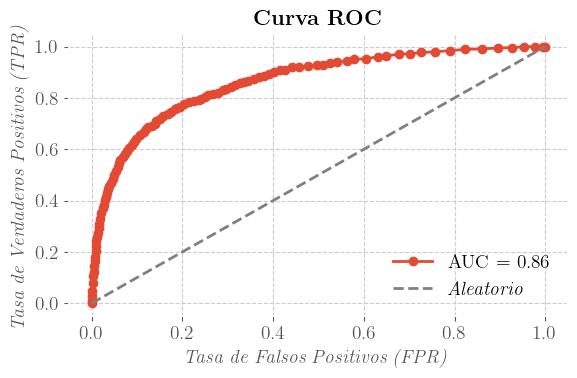

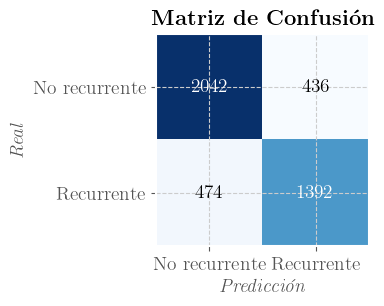

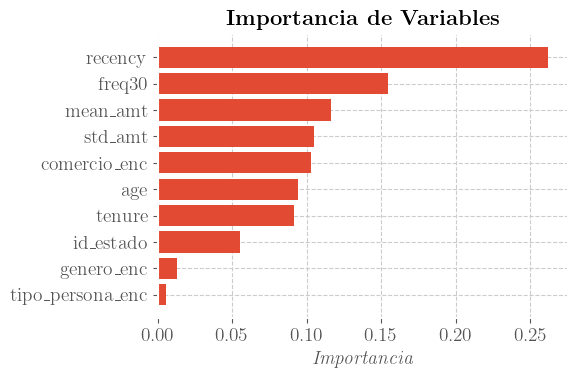

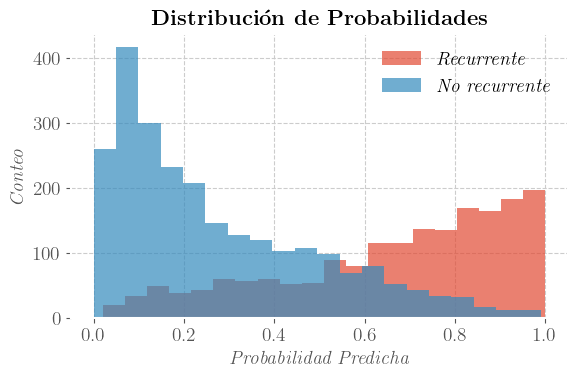

In [15]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix

# —— Estilo con LaTeX habilitado ——
plt.style.use('ggplot')
mpl.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'font.serif': ['Computer Modern'],
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'axes.linewidth': 1.5,
    'lines.linewidth': 2,
    'lines.markersize': 6,
    'axes.grid': True,
    'grid.color': '#CCCCCC',
    'grid.linestyle': '--',
    'grid.linewidth': 0.8,
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'legend.frameon': False,
})

# Asegúrate de haber ejecutado antes tu pipeline:
# X_train, X_test, y_train, y_test, model

# Predicciones
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred       = model.predict(X_test)

# 1) Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc     = auc(fpr, tpr)
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(fpr, tpr, marker='o', label=rf"AUC = {roc_auc:.2f}")
ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label=r'\textit{Aleatorio}')
ax.set(
    title=r'\textbf{Curva ROC}',
    xlabel=r'\textit{Tasa de Falsos Positivos (FPR)}',
    ylabel=r'\textit{Tasa de Verdaderos Positivos (TPR)}'
)
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()

# 2) Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)
clases = ['No recurrente', 'Recurrente']
fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(cm, cmap='Blues')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j],
                ha='center', va='center',
                color='white' if cm[i, j] > cm.max() / 2 else 'black')
ax.set(
    title=r'\textbf{Matriz de Confusión}',
    xticks=[0, 1], xticklabels=clases,
    yticks=[0, 1], yticklabels=clases,
    xlabel=r'\textit{Predicción}',
    ylabel=r'\textit{Real}'
)
plt.tight_layout()
plt.show()

# 3) Importancia de Características
importancias = model.feature_importances_
indices     = np.argsort(importancias)
fig, ax     = plt.subplots(figsize=(6, 4))
ax.barh(range(len(indices)), importancias[indices])
ax.set(
    title=r'\textbf{Importancia de Variables}',
    yticks=range(len(indices)),
    yticklabels=X_test.columns[indices],
    xlabel=r'\textit{Importancia}'
)
plt.tight_layout()
plt.show()

# 4) Distribución de Probabilidades Predichas
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(y_pred_proba[y_test == 1], bins=20, alpha=0.7, label=r'\textit{Recurrente}')
ax.hist(y_pred_proba[y_test == 0], bins=20, alpha=0.7, label=r'\textit{No recurrente}')
ax.set(
    title=r'\textbf{Distribución de Probabilidades}',
    xlabel=r'\textit{Probabilidad Predicha}',
    ylabel=r'\textit{Conteo}'
)
ax.legend()
plt.tight_layout()
plt.show()


In [3]:

cat_cols = ['comercio', 'tipo_persona', 'genero']
num_cols = ['recency', 'freq30', 'mean_amt', 'std_amt',
            'id_estado', 'age', 'tenure']

# OrdinalEncoder que asigna -1 a cualquier categoría desconocida
ord_enc = OrdinalEncoder(
    handle_unknown='use_encoded_value',
    unknown_value=-1
)

preproc = ColumnTransformer([
    ('cat', ord_enc, cat_cols),
    ('num', 'passthrough', num_cols)
])

pipeline = Pipeline([
    ('prep', preproc),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Entrena con tus datos (df del script anterior)
X = df[cat_cols + num_cols]
y = df['label']

pipeline.fit(X, y)

# Guarda el pipeline completo
joblib.dump(pipeline, 'pipeline_completo.pkl')


['pipeline_completo.pkl']

In [ ]:


# Carga el pipeline que ya maneja categorías desconocidas
pipeline = joblib.load('pipeline_completo.pkl')

X_new = pd.DataFrame([{
    'recency':    10,
    'freq30':     2,
    'mean_amt':  50.0,
    'std_amt':    5.0,
    'id_estado': 19,
    'age':       28.5,
    'tenure':   400,
    'comercio': 'AMAZON',
    'tipo_persona': 'Individual',  # aunque no se viera en el fit, será codificado
    'genero': 'M'
}])

prob = pipeline.predict_proba(X_new)[0,1]
pred = pipeline.predict(X_new)[0]

print(f'Probabilidad de transacción en AMAZON: {prob:.2%}')
print(f'Predicción binaria: {pred}')


Probabilidad de transacción en AMAZON: 74.00%
Predicción binaria: 1


In [17]:
# después de construir df_features…
num_cols = ['recency','freq30','mean_amt','std_amt','id_estado','age','tenure']

# Rellenar NaN en todas las columnas numéricas con 0
df_features[num_cols] = df_features[num_cols].fillna(0)

# Ahora sí:
probs = pipeline.predict_proba(df_features)[:,1]
preds = pipeline.predict(df_features)


In [4]:
import pandas as pd
import joblib
from datetime import timedelta

# 1) Carga del pipeline ya entrenado (que no incluye imputer)
pipeline = joblib.load('pipeline_completo.pkl')

# 2) Definir horizonte y fecha de corte
transactions = pd.read_csv('base_transacciones_final.csv', parse_dates=['fecha'])
horizon_days = 30
cutoff_date  = transactions['fecha'].max() - timedelta(days=horizon_days)

# 3) Generar los mismos features para todos los pares (id, comercio)
tx_train = transactions[transactions['fecha'] <= cutoff_date]
clients  = pd.read_csv('base_clientes_final.csv', parse_dates=['fecha_nacimiento','fecha_alta'])
clients['age']    = (cutoff_date - clients['fecha_nacimiento']).dt.days / 365
clients['tenure'] = (cutoff_date - clients['fecha_alta']).dt.days

records = []
for (cid, com), grp in tx_train.groupby(['id','comercio']):
    records.append({
        'id':          cid,
        'comercio':    com,
        'recency':     (cutoff_date - grp['fecha'].max()).days,
        'freq30':      grp[grp['fecha'] >= cutoff_date - timedelta(days=horizon_days)].shape[0],
        'mean_amt':    grp['monto'].mean(),
        'std_amt':     grp['monto'].std(),
        'id_estado':   clients.loc[clients.id==cid, 'id_estado'].iat[0],
        'age':         clients.loc[clients.id==cid, 'age'].iat[0],
        'tenure':      clients.loc[clients.id==cid, 'tenure'].iat[0],
        'tipo_persona':clients.loc[clients.id==cid, 'tipo_persona'].iat[0],
        'genero':      clients.loc[clients.id==cid, 'genero'].iat[0]
    })

df_features = pd.DataFrame(records)

# 3.1) Imputar NaN en numéricas y rellenar genero vacío
num_cols = ['recency','freq30','mean_amt','std_amt','id_estado','age','tenure']
df_features[num_cols] = df_features[num_cols].fillna(0)
df_features['genero'] = df_features['genero'].fillna('')

# 4) Ejecutar predicción en batch
probs = pipeline.predict_proba(df_features)[:,1]
preds = pipeline.predict(df_features)

# 5) Añadir resultados
df_features['p_recurrente']    = probs
df_features['pred_recurrente'] = preds

print(df_features.head())


                                         id         comercio  recency  freq30  \
0  003d9abe467a91847d566cf455bd2d7d6c8f7e75           AMAZON      151       0   
1  003d9abe467a91847d566cf455bd2d7d6c8f7e75     AMAZON PRIME       15       1   
2  003d9abe467a91847d566cf455bd2d7d6c8f7e75  CASHI ECOMMERCE      356       0   
3  003d9abe467a91847d566cf455bd2d7d6c8f7e75        CINEPOLIS        3       1   
4  003d9abe467a91847d566cf455bd2d7d6c8f7e75             DIDI      125       0   

    mean_amt       std_amt  id_estado        age  tenure  \
0  23.481905  3.161686e+01         61  24.860274    1106   
1  11.620000  1.848891e-15         61  24.860274    1106   
2  18.520000  0.000000e+00         61  24.860274    1106   
3  35.975000  9.108626e+00         61  24.860274    1106   
4   7.855467  1.781041e+00         61  24.860274    1106   

                               tipo_persona genero  p_recurrente  \
0  Persona Fisica Sin Actividad Empresarial      M          0.04   
1  Persona Fisic

In [ ]:
ids_unicos = df_features['id'].unique()
print(ids_unicos)

id_elegido = input("Introduce el ID que quieres ver: ")
df_id = df_features[df_features['id'] == id_elegido]
print(df_id)


['003d9abe467a91847d566cf455bd2d7d6c8f7e75'
 '0066f66c7fb0d1102f9f924a56ff65a5fcaf3cea'
 '0132462ee1acf1c37e7411b20bac94e1d19959df'
 '0172891ba3000c3150a6985265517678ebbf3b39'
 '01d12d1c5b58348995b71cf1d5eb9257fa64d95b'
 '0222064a58a1778a4d7a9e10088174a532e71553'
 '0225c1f9c7e66dc02b44b9a00cdd0fa9ba5a4c71'
 '029be42d942d33a14cafeef661143d8940a9efa8'
 '02a73132fe5c2af6d596eec88629c754d9e9c860'
 '02b41a28e9c440a28577c71daec52258dc817866'
 '03a0f8bca94b5801342b9b479213fc548b3f0dd1'
 '0431ee5805e9638f3b24d93812182ec88d7b8c20'
 '0471167c6dcd9e87952bee4478ce26337793c07f'
 '04e15785e1f1d2a4893438cf2c5ec8036eea4e36'
 '04fd28294e679ea9848b3057862a6bf40367331e'
 '054be5f40d50b28d2b82af57159343989dd28012'
 '064a7e19386fffe76845c0af12b8971542af1270'
 '0686ef5970f3e3e29ba54c0e82c22364cb1ade90'
 '068a3a4901e7819ac41bfd214b724a4094baa6fc'
 '06a11e73530670c0ab02598f0a621b84ffc894ce'
 '06ca5015907f43d644fd5a91ede20434f6fecafc'
 '06edf585cd7a632155cf063b328033ffbfa7ae69'
 '072b18c67074cbfff8122908e96cce

In [6]:
id_primer = df_features.iloc[0]['id']
df_id_comercios = df_features[df_features['id'] == id_primer]
print(df_id_comercios[['comercio', 'p_recurrente']])



           comercio  p_recurrente
0            AMAZON          0.04
1      AMAZON PRIME          0.96
2   CASHI ECOMMERCE          0.04
3         CINEPOLIS          0.16
4              DIDI          0.06
5         DIDI FOOD          0.09
6        DIDI RIDES          0.99
7          DIDIFOOD          0.04
8            ITUNES          0.70
9        KUESKI PAY          0.91
10     MERCADO PAGO          0.79
11      MERCADOPAGO          0.08
12        MICROSOFT          0.65
13             OXXO          0.73
14            RAPPI          0.09
15        SAMS CLUB          0.09
16          SPOTIFY          0.97
17        STARBUCKS          0.20
18      SUPERCENTER          0.00
19        TOTALPLAY          0.05
20             UBER          0.99
21        UBER EATS          0.87
22          WALMART          0.16


In [13]:
import matplotlib.pyplot as plt

# Configuración para usar LaTeX en los textos
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
})

# Asumiendo que `transactions` y `df_features` ya están definidos
id_primer = df_features.iloc[0]['id']

# Filtrar transacciones de ese usuario en 'UBER'
df_uber = transactions[
    (transactions['id'] == id_primer) &
    (transactions['comercio'].str.upper() == 'UBER')
]

# Dibujar histograma sin grid, bins blancos y texto blanco
fig, ax = plt.subplots(figsize=(6, 4))
fig.patch.set_alpha(0)       # fondo del figure transparente
ax.set_facecolor('none')     # fondo del axes transparente

# Histograma con barras blancas
ax.hist(df_uber['monto'], bins=10, color='white', edgecolor='black')

# Etiquetas en blanco
ax.set_xlabel(r'\textit{Monto de la transacción} (\$)', color='white')
ax.set_ylabel(r'\textit{Conteo}', color='white')

# Ejes y ticks en blanco
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
for spine in ax.spines.values():
    spine.set_edgecolor('white')

plt.tight_layout()

# Guardar como PNG con fondo transparente
plt.savefig('hist_uber.png', dpi=300, transparent=True, bbox_inches='tight')
plt.close(fig)



### COSTOS

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, FunctionTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import joblib

# 1) Carga de datos
clients = pd.read_csv('base_clientes_final.csv', parse_dates=['fecha_nacimiento','fecha_alta'])
transactions = pd.read_csv('base_transacciones_final.csv', parse_dates=['fecha'])

# 2) Horizonte y fecha de corte
horizon_days = 30
cutoff_date = transactions['fecha'].max() - timedelta(days=horizon_days)

# 3) Histórico y futuro
tx_train = transactions[transactions['fecha'] <= cutoff_date]
tx_future = transactions[
    (transactions['fecha'] > cutoff_date) &
    (transactions['fecha'] <= cutoff_date + timedelta(days=horizon_days))
]

# 4) Target: monto total futuro (>0)
future_sum = tx_future.groupby(['id','comercio'])['monto'].sum().reset_index()
future_sum.rename(columns={'monto':'target_amt'}, inplace=True)

# 5) Features igual que clasificación
records = []
for (cid, com), grp in tx_train.groupby(['id','comercio']):
    recency =   (cutoff_date - grp['fecha'].max()).days
    freq30  =   grp[grp['fecha'] >= cutoff_date - timedelta(days=horizon_days)].shape[0]
    mean_amt=   grp['monto'].mean()
    std_amt =   grp['monto'].std()
    records.append([cid, com, recency, freq30, mean_amt, std_amt])
feat = pd.DataFrame(records, columns=['id','comercio','recency','freq30','mean_amt','std_amt'])

clients['age']    = (cutoff_date - clients['fecha_nacimiento']).dt.days / 365
clients['tenure'] = (cutoff_date - clients['fecha_alta']).dt.days

df = (feat
      .merge(clients[['id','id_estado','age','tenure','tipo_persona','genero']], on='id', how='left')
      .merge(future_sum, on=['id','comercio'], how='left')
      .fillna({'std_amt':0, 'target_amt':0, 'genero':''}))

# 6) Entrenar solo sobre casos con target>0
df_pos = df[df['target_amt'] > 0].copy()
df_pos['log_amt'] = np.log1p(df_pos['target_amt'])

# 7) Split train-test
cat_cols = ['comercio','tipo_persona','genero']
num_cols = ['recency','freq30','mean_amt','std_amt','id_estado','age','tenure']
X_train, X_test, y_train, y_test = train_test_split(
    df_pos[cat_cols + num_cols], df_pos['log_amt'],
    test_size=0.2, random_state=42
)

# 8) Pipeline: codificar + regressor con nativamente imputer
preproc = ColumnTransformer([
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols),
    ('num', 'passthrough', num_cols)
])

reg_pipeline = Pipeline([
    ('prep', preproc),
    ('reg', HistGradientBoostingRegressor(
        max_iter=200, random_state=42
    ))
])

# 9) Entrenamiento
reg_pipeline.fit(X_train, y_train)

# 10) Evaluación en test (convertir log back)
y_pred_log = reg_pipeline.predict(X_test)
rmse = mean_squared_error(np.expm1(y_test), np.expm1(y_pred_log), squared=False)
print(f'RMSE en test (escala real): {rmse:.2f}')

# 11) Guardar pipeline de regresión mejorado
joblib.dump(reg_pipeline, 'pipeline_regresion_monto_mejorado.pkl')


RMSE en test (escala real): 237.09


['pipeline_regresion_monto_mejorado.pkl']

In [22]:
import pandas as pd
import joblib
from datetime import timedelta

# Carga ambos pipelines
clf = joblib.load('pipeline_completo.pkl')
reg = joblib.load('pipeline_regresion_monto.pkl')

# Reconstruye df_features tal como antes (sin NaN)
# … tu código para df_features …

# Inferencia en batch
df_features['p_compra']     = clf.predict_proba(df_features)[:,1]
df_features['pred_compra']  = clf.predict(df_features)
df_features['monto_predicho'] = reg.predict(df_features)

# Vista rápida
print(df_features[['id','comercio',
                   'p_compra','pred_compra','monto_predicho']].head())


                                         id         comercio  p_compra  \
0  003d9abe467a91847d566cf455bd2d7d6c8f7e75           AMAZON      0.04   
1  003d9abe467a91847d566cf455bd2d7d6c8f7e75     AMAZON PRIME      0.96   
2  003d9abe467a91847d566cf455bd2d7d6c8f7e75  CASHI ECOMMERCE      0.04   
3  003d9abe467a91847d566cf455bd2d7d6c8f7e75        CINEPOLIS      0.16   
4  003d9abe467a91847d566cf455bd2d7d6c8f7e75             DIDI      0.06   

   pred_compra  monto_predicho  
0            0          2.4876  
1            1         11.3876  
2            0          0.2483  
3            0          5.5428  
4            0          0.4164  


In [10]:
import pandas as pd
import joblib

# 1) Cargar tu pipeline entrenado
pipeline = joblib.load('pipeline_completo.pkl')

# 2) Suponiendo que ya tienes tu DataFrame 'df' con todas las features
#    (es el mismo que usaste para entrenar, menos la columna 'label')
cat_cols = ['comercio','tipo_persona','genero']
num_cols = ['recency','freq30','mean_amt','std_amt','id_estado','age','tenure']

X_all = df[cat_cols + num_cols]

# 3) Generar predicciones en batch
probs  = pipeline.predict_proba(X_all)[:,1]   # vector de probabilidades
preds  = pipeline.predict(X_all)              # vector de clases 0/1

# 4) Volcar resultados
df['p_recurrente'] = probs
df['pred_recurrente'] = preds

# 5) Por ejemplo, ver los top 5 clientes más propensos a volver a comprar en AMAZON
amazon_df = df[df['comercio']=='AMAZON']
top5 = amazon_df.sort_values('p_recurrente', ascending=False).head(5)
print(top5[['id','comercio','p_recurrente','pred_recurrente']])


                                             id comercio  p_recurrente  \
17992  d46735a55e1a241b30914f622d24cb7edfd3b2e5   AMAZON           1.0   
1707   178038e16a3c24e9bca0a9ffb60b43fb8f320f70   AMAZON           1.0   
19259  e300be1e9145c31ef23005d864aad37b9e490e7e   AMAZON           1.0   
18131  d5ef307a89fc28160c77c08bb2ee23de60d298cb   AMAZON           1.0   
943    0e91fc4b2fd7104e53c57c2500fc15deaa0c335f   AMAZON           1.0   

       pred_recurrente  
17992                1  
1707                 1  
19259                1  
18131                1  
943                  1  
